In [109]:
import os
import operator
import random
import numpy as np
import pandas as pd
import csv

from itertools import chain, islice
from functools import partial

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import backend as K

import tensorflow as tf

import matplotlib.pyplot as plt
from pprint import pprint

import gc

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.set_random_seed(seed)
    
set_seed(1992)

<h2>Preprocessing</h2>
<p>We load the <i>LingSpam</i> dataset and split the data in training, validation and test sets</p>

In [3]:
root = "lingspam_public/bare"

In [4]:
ham, spam = [], []

for dirpath, _, filenames in os.walk(root):
    for filename in filenames:
        with open(os.path.join(dirpath, filename), encoding="utf8") as file:
            message = file.read()
        if filename.startswith("spm"):
            spam.append(message)
        else:
            ham.append(message)
            
print("Ham: {}, Spam: {}".format(len(ham), len(spam)))

Ham: 2412, Spam: 481


In [5]:
def data_split(x, y, sizes=(0.1, 0.1)):
    
    data_size = len(x)
    splits = []
    
    for size in sizes:
        x, test_x, y, test_y = train_test_split(x, y, test_size=int(data_size*size), shuffle=True)
        splits.append((test_x, test_y))
    splits.append((x, y))
    
    return splits

x = ham + spam
y = [0] * len(ham) + [1] * len(spam)

(test_x, test_y), (valid_x, valid_y), (train_x, train_y) = data_split(x, y, sizes=(0.2, 0.08))

print("Split Sizes: {}".format(list(map(len, (train_x, valid_x, test_x)))))

Split Sizes: [2084, 231, 578]


<h3>Tokenizer Initialization</h3>
<p>We consider three tokenizers. <i>Tokenizer_GLB</i> is fitted in all token in both the training and validation data. <i>Tokenizer_TRAIN_GLB</i> is fitted in all tokens onservable in the training set. <i>Tokenizer_UNK</i> is fitted in a subset of the training sequences in order to simulate the unobservability of a number of tokens in the validation data.</p>

In [83]:
tokenizer_GLB = Tokenizer(num_words=None, lower=True, oov_token="*UNK*")
tokenizer_GLB.fit_on_texts(chain(train_x, valid_x))

print("Tokens discovered by Tokenizer_GLB: {}".format(len(tokenizer_GLB.word_index)))

Tokens discovered by Tokenizer_GLB: 53917


In [84]:
tokenizer_TRAIN_GLB = Tokenizer(num_words=None, lower=True, oov_token="*UNK*")
tokenizer_TRAIN_GLB.fit_on_texts(train_x)

print("Tokens discovered by Tokenizer_TRAIN_GLB: {}".format(len(tokenizer_TRAIN_GLB.word_index)))

Tokens discovered by Tokenizer_TRAIN_GLB: 50155


In [85]:
tokenizer_UNK = Tokenizer(num_words=None, lower=True, oov_token="*UNK*")
tokenizer_UNK.fit_on_texts(random.sample(train_x, len(train_x) - len(valid_x))) # We want the number of unknown words in the train set to be approximately the same as in the validation set.

print("Tokens discovered by Tokenizer_UNK: {}".format(len(tokenizer_UNK.word_index)))

Tokens discovered by Tokenizer_UNK: 46737


<h3>Tokenization</h3>
<p>We transform each set in sequences of tokens according the chosen tokenizer.</p>

In [86]:
tokenizer = tokenizer_UNK

In [87]:
train_sequences = pad_sequences(tokenizer.texts_to_sequences(train_x), maxlen=150, padding="post", truncating="post") # We are contrained by the hardware limitations.
input_length = len(train_sequences[0])

In [88]:
valid_sequences = pad_sequences(tokenizer.texts_to_sequences(valid_x), maxlen=input_length, padding="post", truncating="post")
test_sequences  = pad_sequences(tokenizer.texts_to_sequences(test_x), maxlen=input_length, padding="post", truncating="post")

<h2>Utilities</h2>

In [12]:
def clean_model(model):
    
    K.clear_session()
    del model
    gc.collect()
    
    
def plot_history(history):
    
    plt.plot(
        history.history["acc"],
        label="Train"
    )
    plt.plot(
        history.history["val_acc"],
        label="Validation"
    )
    
    plt.title("Model Accuracy")
    plt.ylabel("Accuray")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="best")
    
    plt.show()
    

def evaluate_model(model, sequences, y):
    
    print(classification_report(y, (model.predict(sequences).flatten() >= 0.5).astype(float)))

<h2>MLP on Pretrained (Glove) Embeddings</h2>

In [98]:
glove_embeddings_path = "glove.6B/glove.6B.100d.txt"
embeddings_df = pd.read_csv(glove_embeddings_path, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE, na_values=None, keep_default_na=False)

In [99]:
token_iter = map(
    operator.itemgetter(0),
    sorted(
        filter(lambda item: item[1] <= tokenizer.num_words, tokenizer.word_index.items()) if tokenizer.num_words
            else tokenizer.word_index.items(),
        key=operator.itemgetter(1)
    )
)

embedding_weights = embeddings_df.reindex(chain((None,), token_iter), fill_value=0.0).values # The zero-indexed vector is used only for masking by the layer.

print("Non-Zero Embeddings: {}".format(np.count_nonzero(embedding_weights, axis=0)[0]))

Non-Zero Embeddings: 31799


In [121]:
model = Sequential(name="MLP")

model.add(Embedding(
    input_dim=embedding_weights.shape[0],
    output_dim=embedding_weights.shape[1],
    input_length=input_length,
    embeddings_initializer="zeros",
    weights=[embedding_weights],
    trainable=False
))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          4673800   
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1500100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 6,174,001
Trainable params: 1,500,201
Non-trainable params: 4,673,800
_________________________________________________________________


In [122]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [123]:
history = model.fit(
    train_sequences, train_y,
    validation_data=(valid_sequences, valid_y),
    batch_size=16,
    epochs=100,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True, verbose=1)],
    verbose=1
)

Train on 2084 samples, validate on 231 samples
Epoch 1/100
2084/2084 [==============================] - 2s 822us/step - loss: 0.4411 - acc: 0.8637 - val_loss: 0.0988 - val_acc: 0.9827
Epoch 2/100
2084/2084 [==============================] - 1s 431us/step - loss: 0.1110 - acc: 0.9597 - val_loss: 0.0525 - val_acc: 0.9827
Epoch 3/100
2084/2084 [==============================] - 1s 429us/step - loss: 0.0624 - acc: 0.9760 - val_loss: 0.0285 - val_acc: 1.0000
Epoch 4/100
2084/2084 [==============================] - 1s 438us/step - loss: 0.0425 - acc: 0.9866 - val_loss: 0.0241 - val_acc: 0.9913
Epoch 5/100
2084/2084 [==============================] - 1s 421us/step - loss: 0.0386 - acc: 0.9880 - val_loss: 0.0319 - val_acc: 0.9870
Epoch 6/100
2084/2084 [==============================] - 1s 445us/step - loss: 0.0299 - acc: 0.9894 - val_loss: 0.0316 - val_acc: 0.9913
Epoch 7/100
2084/2084 [==============================] - 1s 437us/step - loss: 0.0201 - acc: 0.9928 - val_loss: 0.0332 - val_acc: 0

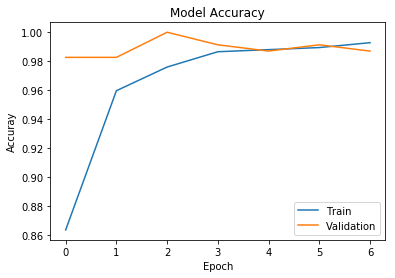

In [124]:
plot_history(history)

In [125]:
evaluate_model(model, train_sequences, train_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1740
           1       1.00      1.00      1.00       344

   micro avg       1.00      1.00      1.00      2084
   macro avg       1.00      1.00      1.00      2084
weighted avg       1.00      1.00      1.00      2084



In [126]:
evaluate_model(model, valid_sequences, valid_y)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       192
           1       1.00      0.95      0.97        39

   micro avg       0.99      0.99      0.99       231
   macro avg       0.99      0.97      0.98       231
weighted avg       0.99      0.99      0.99       231



In [127]:
evaluate_model(model, test_sequences, test_y)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       480
           1       0.95      0.93      0.94        98

   micro avg       0.98      0.98      0.98       578
   macro avg       0.97      0.96      0.96       578
weighted avg       0.98      0.98      0.98       578



In [120]:
clean_model(model)